In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
# import itertools
from scipy.interpolate import InterpolatedUnivariateSpline

from load_data import get_pos, get_spikes
from maze_functions import find_zones, trajectory_fields
from plotting_functions import plot_intersects, plot_zone
from decode_functions import get_edges

import vdmlab as vdm

In [ ]:
xy = np.array([[2, 7],
               [4, 5],
               [6, 3],
               [8, 1],
               [2, 4]])
time = np.array([0., 1., 2., 3., 4.])
position = vdm.Position(xy, time)

In [ ]:
plt.plot(position.x, position.y, 'b.', ms=10)
plt.xlim(0.5, 8.5)
plt.ylim(0.5, 7.5)
plt.show()

In [ ]:
spikes = [vdm.SpikeTrain(np.array([3.6, 3.9])), 
          vdm.SpikeTrain(np.array([0., 0., 2.])),
          vdm.SpikeTrain(np.array([2., 2.4]))]

In [ ]:
binsize = 2
xedges = np.arange(position.x.min(), position.x.max()+binsize, binsize)
yedges = np.arange(position.y.min(), position.y.max()+binsize, binsize)

tuning_curves = vdm.tuning_curve_2d(position, spikes, xedges, yedges, sampling_rate=1.)

In [ ]:
plt.figure()
xx, yy = np.meshgrid(xedges, yedges)
for tuning_curve in tuning_curves:
    pp = plt.pcolormesh(xx, yy, tuning_curve, cmap='YlGn')
    plt.colorbar(pp)
    plt.axis('off')
    plt.show()

In [ ]:
counts_binsize = 0.5

time_edges = get_edges(position, counts_binsize, lastbin=True)
counts = vdm.get_counts(spikes, time_edges, apply_filter=False)

In [ ]:
print(time_edges)

In [ ]:
print(counts)

In [ ]:
decoding_tc = []
for tuning_curve in tuning_curves:
    decoding_tc.append(np.ravel(tuning_curve))
decoding_tc = np.array(decoding_tc)

In [ ]:
shape = tuning_curves[0].shape

In [ ]:
tuning_curves

In [ ]:
decoding_tc

In [ ]:
likelihood = vdm.bayesian_prob(counts, decoding_tc, counts_binsize)

In [ ]:
likelihood

In [ ]:
xcenters = (xedges[1:] + xedges[:-1]) / 2.
ycenters = (yedges[1:] + yedges[:-1]) / 2.
xy_centers = vdm.cartesian(xcenters, ycenters)

time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

In [ ]:
time_centers

In [ ]:
decoded = vdm.decode_location(likelihood, xy_centers, time_centers)

In [ ]:
decoded.x, decoded.y, decoded.time

In [ ]:
nan_idx = np.logical_and(np.isnan(decoded.x), np.isnan(decoded.y))
decoded = decoded[~nan_idx]

In [ ]:
decoded.x, decoded.y, decoded.time

In [ ]:
x_spline = InterpolatedUnivariateSpline(position.time, position.x)
y_spline = InterpolatedUnivariateSpline(position.time, position.y)
actual_position = vdm.Position(np.hstack((x_spline(time_centers)[..., np.newaxis],
                                         (y_spline(time_centers)[..., np.newaxis]))), time_centers)

In [ ]:
actual_position.x, actual_position.y, actual_position.time

In [ ]:
error = np.abs(decoded.data - actual_position.data)

In [ ]:
avg_error = np.nanmean(error)
avg_error

## How does the 1D decoding work?

In [ ]:
x = np.array([2, 4, 6, 8, 3])
time = np.array([0., 1., 2., 3., 4.])
position = vdm.Position(x, time)

In [ ]:
spikes = [vdm.SpikeTrain(np.array([3.6, 3.9])), vdm.SpikeTrain(np.array([2.2, 2.43]))]

In [ ]:
pos_binsize = 1
tuning_curves = vdm.tuning_curve(position, spikes, binsize=pos_binsize, sampling_rate=1., gaussian_std=None)

In [ ]:
tuning_curves

In [ ]:
plt.plot(tuning_curves[0], 'b')
plt.plot(tuning_curves[1], 'm')
plt.show()

In [ ]:
counts_binsize = 0.5
time_edges = get_edges(position, counts_binsize, lastbin=True)
counts = vdm.get_counts(spikes, time_edges)

In [ ]:
time_edges.shape

In [ ]:
counts

In [ ]:
likelihood = vdm.bayesian_prob(counts, tuning_curves, counts_binsize)

In [ ]:
likelihood

In [ ]:
pos_edges = vdm.binned_position(position, pos_binsize)
x_centers = (pos_edges[1:] + pos_edges[:-1]) / 2.
x_centers = x_centers[..., np.newaxis]

time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

decoded = vdm.decode_location(likelihood, x_centers, time_centers)
decoded

In [ ]:
nan_idx = np.isnan(decoded.x)
decoded = decoded[~nan_idx]

In [ ]:
decoded.x, decoded.time

In [ ]:
spline = InterpolatedUnivariateSpline(position.time, position.x)
actual_position = vdm.Position(spline(decoded.time), decoded.time)

In [ ]:
actual_position.x, actual_position.time

In [ ]:
error = np.abs(decoded.x - actual_position.x)

In [ ]:
decoded.x, actual_position.x

In [ ]:
avg_error = np.mean(error)
avg_error

# check velocity 1D

In [ ]:
x = np.array([2, 4, 6, 8, 3])
time = np.array([0., 1., 2., 3., 4.])
position = vdm.Position(x, time)

spikes = [vdm.SpikeTrain(np.array([3.6, 3.9])), 
          vdm.SpikeTrain(np.array([2.2, 2.4])),
          vdm.SpikeTrain(np.array([0.6, 0.9])),
          vdm.SpikeTrain(np.array([1., 1.1])), 
          vdm.SpikeTrain(np.array([1.7, 1.9]))]

pos_binsize = 1
tuning_curves = vdm.tuning_curve(position, spikes, binsize=pos_binsize, sampling_rate=1., gaussian_std=None)

counts_binsize = 0.5
time_edges = get_edges(position, counts_binsize, lastbin=True)
counts = vdm.get_counts(spikes, time_edges)

likelihood = vdm.bayesian_prob(counts, tuning_curves, counts_binsize)

pos_edges = vdm.binned_position(position, pos_binsize)
x_centers = (pos_edges[1:] + pos_edges[:-1]) / 2.
x_centers = x_centers[..., np.newaxis]

time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

decoded = vdm.decode_location(likelihood, x_centers, time_centers)

nan_idx = np.isnan(decoded.x)
decoded = decoded[~nan_idx]

print(decoded.x, decoded.time)

In [ ]:
decode_jumps = vdm.remove_teleports(decoded, speed_thresh=0, min_length=1)

In [ ]:
decode_jumps.time, decode_jumps.x

## Counts filtering parameter check

In [ ]:
std = [0.1, 0.025, 0.01, 0.002, None, 0.5, 1.0]
error = [29.9113296726, 29.3032199091, 45.8427697608, 45.8427697608, 45.8427697608, 28.623598705, 29.0339763118]

In [ ]:
plt.plot(std, error, '.', ms=15)
plt.xlim(-0.1, 1.1)
plt.ylim(25, 48)
plt.show()

## Other stuff

In [2]:

from load_data import get_pos, get_spikes, get_lfp

import info.R063d3_info as r063d3
info = r063d3

In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import InterpolatedUnivariateSpline

import vdmlab as vdm

from load_data import get_pos, get_spikes
from tuning_curves_functions import get_tc_1d, find_ideal
from decode_functions import get_edges

In [4]:
pickle_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\pickled\\'
output_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\plots\\'

R063d3
Actual distance: 29.3032199091
n_samples: 84035


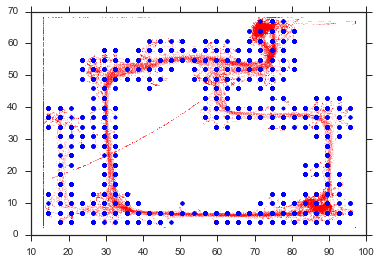

In [5]:
infos = [r063d3]
# infos = [r063d2, r063d3, r063d4, r063d5, r063d6, r066d1, r066d2, r066d3, r066d4, r067d1]


for info in infos:
    print(info.session_id)
    position = get_pos(info.pos_mat, info.pxl_to_cm)
    spikes = get_spikes(info.spike_mat)

    speed = position.speed(t_smooth=0.5)
    run_idx = np.squeeze(speed.data) >= info.run_threshold
    run_pos = position[run_idx]

    track_starts = [info.task_times['phase1'].start, info.task_times['phase2'].start, info.task_times['phase3'].start]
    track_stops = [info.task_times['phase1'].stop, info.task_times['phase2'].stop, info.task_times['phase3'].stop]

    track_pos = run_pos.time_slices(track_starts, track_stops)

    track_spikes = [spiketrain.time_slices(track_starts, track_stops) for spiketrain in spikes]

    binsize = 3
    xedges = np.arange(track_pos.x.min(), track_pos.x.max() + binsize, binsize)
    yedges = np.arange(track_pos.y.min(), track_pos.y.max() + binsize, binsize)

    tuning_curves = vdm.tuning_curve_2d(track_pos, track_spikes, xedges, yedges, gaussian_sigma=0.2)

    counts_binsize = 0.025
    time_edges = get_edges(run_pos, counts_binsize, lastbin=True)
    counts = vdm.get_counts(spikes, time_edges, gaussian_std=counts_binsize)

    decoding_tc = []
    for tuning_curve in tuning_curves:
        decoding_tc.append(np.ravel(tuning_curve))
    decoding_tc = np.array(decoding_tc)

    likelihood = vdm.bayesian_prob(counts, decoding_tc, counts_binsize)

    xcenters = (xedges[1:] + xedges[:-1]) / 2.
    ycenters = (yedges[1:] + yedges[:-1]) / 2.
    xy_centers = vdm.cartesian(xcenters, ycenters)

    time_centers = (time_edges[1:] + time_edges[:-1]) / 2.

    decoded_pos = vdm.decode_location(likelihood, xy_centers, time_centers)
    nan_idx = np.logical_and(np.isnan(decoded_pos.x), np.isnan(decoded_pos.y))
    decoded_pos = decoded_pos[~nan_idx]

    decoded = vdm.remove_teleports(decoded_pos, speed_thresh=10, min_length=3)

    x_spline = InterpolatedUnivariateSpline(track_pos.time, track_pos.x)
    y_spline = InterpolatedUnivariateSpline(track_pos.time, track_pos.y)
    actual_position = vdm.Position(np.hstack((np.clip(x_spline(decoded.time),
                                                      xedges.min(), xedges.max())[..., np.newaxis],
                                             (np.clip(y_spline(decoded.time),
                                                      yedges.min(), yedges.max())[..., np.newaxis]))),
                                   decoded.time)

    errors = actual_position.distance(decoded)
    print('Actual distance:', np.mean(errors))

    print('n_samples:', decoded.n_samples)

    plt.plot(actual_position.x, actual_position.y, 'r.', ms=0.7)
    plt.plot(decoded.x, decoded.y, 'b.')
    plt.show()

In [ ]:
std = 24
test_xy = actual_position.data + np.random.normal(0, std, actual_position.data.shape)
test_pos = vdm.Position(test_xy, actual_position.time)
test_errors = actual_position.distance(test_pos)
print('Test distance:', np.mean(test_errors))

In [ ]:
difference = 32
test_xy = actual_position.data + difference
test_pos = vdm.Position(test_xy, actual_position.time)
test_errors = actual_position.distance(test_pos)
print('Test distance:', np.mean(test_errors))

In [ ]:
plt.plot(test_pos.x, test_pos.y, 'm.', ms=1)
plt.plot(actual_position.x, actual_position.y, 'b.')
plt.show()

In [ ]:
plt.boxplot(errors)
plt.show()

In [ ]:
test_errors.shape

In [6]:
from maze_functions import find_zones
import seaborn as sns

In [7]:
zones = find_zones(info, expand_by=6)

In [8]:
zones.keys()

dict_keys(['u', 'shortcut', 'shortped', 'ushort', 'unovel', 'pedestal', 'novel', 'uped', 'novelped'])

In [9]:
def point_in_zones(position, zones):
    """Assigns points if contained in shortcut zones
    
    Parameters
    ----------
    position : vdmlab.Position
    zones : dict
        With u, ushort, unovel, shortcut, shortped, novel, novelped, pedestal as keys
        
    Returns
    -------
    sorted_zones : dict
        With u, shortcut, novel, other as keys, each a vdmlab.Position object
        
    """
    u_data = []
    u_times = []
    shortcut_data = []
    shortcut_times = []
    novel_data = []
    novel_times = []
    other_data = []
    other_times = []
    
    for x, y, time in zip(position.x, position.y, position.time):
        point = Point([x, y])
        if zones['u'].contains(point) or zones['ushort'].contains(point) or zones['unovel'].contains(point):
            u_data.append([x, y])
            u_times.append(time)
        if zones['shortcut'].contains(point) or zones['shortped'].contains(point):
            shortcut_data.append([x, y])
            shortcut_times.append(time)
        if zones['novel'].contains(point) or zones['novelped'].contains(point):
            novel_data.append([x, y])
            novel_times.append(time)
        else:
            other_data.append([x, y])
            other_times.append(time)
            
    sorted_zones = dict()
    sorted_zones['u'] = vdm.Position(u_data, u_times)
    sorted_zones['shortcut'] = vdm.Position(shortcut_data, shortcut_times)
    sorted_zones['novel'] = vdm.Position(novel_data, novel_times)
    sorted_zones['other'] = vdm.Position(other_data, other_times)
    
    return sorted_zones

In [10]:
sorted_zones = point_in_zones(actual_position, zones)

In [11]:
total_actual = (len(sorted_zones['novel'].time) + 
                len(sorted_zones['shortcut'].time) + 
                len(sorted_zones['u'].time) + 
                len(sorted_zones['other'].time))
total_actual

153638

In [12]:
decoded_zones = point_in_zones(decoded, zones)

In [13]:
total_decoded = (len(decoded_zones['u'].time) +
                 len(decoded_zones['shortcut'].time) +
                 len(decoded_zones['novel'].time) +
                 len(decoded_zones['other'].time))
total_decoded     

149464

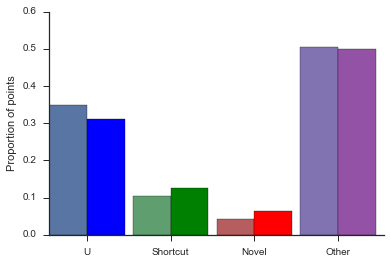

In [14]:
n_groups = np.arange(4)
width = 0.45
colour = ['#5975a4', '#5f9e6e', '#b55d5f', '#8172b2']
actual = [len(sorted_zones['u'].time)/total_actual, 
          len(sorted_zones['shortcut'].time)/total_actual, 
          len(sorted_zones['novel'].time)/total_actual,
          len(sorted_zones['other'].time)/total_actual]
decode = [len(decoded_zones['u'].time)/total_decoded, 
          len(decoded_zones['shortcut'].time)/total_decoded, 
          len(decoded_zones['novel'].time)/total_decoded,
          len(decoded_zones['other'].time)/total_decoded]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(n_groups, actual, width, color=colour)
ax.bar(n_groups+width, decode, width, color=['b', 'g', 'r', '#9452a7'])
# for i in range(len(actual)):
#     ax.bar(n_groups[i], actual[i], align='center', color=colour[i])
plt.ylabel('Proportion of points')
sns.despine()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(n_groups + width)
ax.set_xticklabels(['U', 'Shortcut', 'Novel', 'Other'])
plt.show()

In [ ]:
n_groups = list(range(3))
colour = ['#5975a4', '#5f9e6e', '#b55d5f']
actual = [len(sorted_zones['u'].time)/total_actual, 
          len(sorted_zones['shortcut'].time)/total_actual, 
          len(sorted_zones['novel'].time)/total_actual]
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(actual)):
    ax.bar(n_groups[i], actual[i], align='center', color=colour[i])
plt.ylabel('Proportion of points')
# sns.despine()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(n_groups, ['U', 'Shortcut', 'Novel'])
plt.show()

In [ ]:
n_groups = list(range(3))
colour = ['#5975a4', '#5f9e6e', '#b55d5f']
decode = [len(decoded_zones['u'].time)/total_decoded, 
          len(decoded_zones['shortcut'].time)/total_decoded, 
          len(decoded_zones['novel'].time)/total_decoded]
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(len(decode)):
    ax.bar(n_groups[i], decode[i], align='center', color=colour[i])
plt.ylabel('Proportion of points')
# sns.despine()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(n_groups, ['U', 'Shortcut', 'Novel'])
plt.show()

In [ ]:
pos = np.random.rand(20, 2)

In [ ]:
pos

In [ ]:
split_idx = np.array([4, 6, 10])

In [ ]:
all_idx = [idx for idx in np.split(np.arange(pos.shape[0]), split_idx) if idx.size > 3]

In [ ]:
pos[np.hstack(all_idx)]

In [ ]:
time = np.linspace(0, np.pi*2, 201)
data = np.hstack((np.sin(time)))

In [ ]:
plt.plot(time, data, '.')
plt.show()

In [ ]:
position = vdm.Position(data, time)

In [ ]:
speed = position.speed()

In [ ]:
plt.plot(speed.time, speed.data)
plt.show()

In [ ]:
run_idx = np.squeeze(speed.data) >= 0.5

In [ ]:
run_idx

In [ ]:
position = vdm.Position(data, time)
speed = position.speed()
run_idx = np.squeeze(speed.data) >= 0.7
run_position = position[run_idx]

len(run_position.x)

In [ ]:
assert np.allclose(len(run_position.x), 100)

In [ ]:
velocity = self[1:].distance(self[:-1])
velocity /= np.diff(self.time)
velocity = np.hstack(([0], velocity))

if t_smooth is not None:
    dt = np.median(np.diff(self.time))
    filter_length = np.ceil(t_smooth / dt)
    velocity = np.convolve(velocity, np.ones(int(filter_length))/filter_length, 'same')

return AnalogSignal(velocity, self.time)

In [ ]:
t_smooth=0.5
velocity = np.diff(np.squeeze(position.data))
velocity /= np.diff(position.time)
velocity = np.hstack(([0], velocity))

dt = np.median(np.diff(position.time))
filter_length = np.ceil(t_smooth / dt)
velocity = np.convolve(velocity, np.ones(int(filter_length))/filter_length, 'same')

In [ ]:
velocity

In [ ]:
a = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
a

In [ ]:
np.hstack((a[0:2], a[6:8]))

In [ ]:
indices = []
for t_start, t_stop in zip(np.array([0, 6]), np.array([2, 8])):
    indices.append((a >= t_start) & (a <= t_stop))
indices = np.any(np.column_stack((indices)),axis=1)
a[indices]

In [ ]:
res = np.any(np.column_stack((indices)),axis=1)
res

In [ ]:
spikes = [vdm.SpikeTrain(np.array([0., 0., 1.])), vdm.SpikeTrain(np.array([3.6, 3.9]))]

In [ ]:
one_line = LineString([[2, 0], [2, 2], [2, 4], [2, 6], [2, 8], [2, 10]])

one_start = Point([2, 2])
one_stop = Point([2, 8])

expand_by = 1

one_zone = vdm.expand_line(one_start, one_stop, one_line, expand_by)

In [ ]:
this_idx = []
for pos_idx in range(len(position.time)):
    point = Point([position.x[pos_idx], position.y[pos_idx]])
    if one_zone.contains(point):
        this_idx.append(pos_idx)
        
this_pos = position[this_idx]
linear = this_pos.linearize(one_line, one_zone)

In [ ]:
linear.x

In [ ]:
plt.plot(position.x, position.y, 'g.', ms=10)
# plt.plot([2, 4, 2], [7, 5, 4], 'm.', ms=20)
plt.plot([2, 6], [4, 3], 'm.', ms=20)
plt.plot(one_zone.exterior.xy[0], one_zone.exterior.xy[1], 'b', lw=1)
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.show()

In [ ]:
def expand_line(start_pt, stop_pt, line, expand_by):
    line_expanded = line.buffer(expand_by)
    zone = start_pt.union(line_expanded).union(stop_pt)
    
    return zone

def find_zones(info, expand_by=6):
    u_line = LineString(info.u_trajectory)
    shortcut_line = LineString(info.shortcut_trajectory)
    novel_line = LineString(info.novel_trajectory)

    u_start = Point(info.u_trajectory[0])
    u_stop = Point(info.u_trajectory[-1])
    shortcut_start = Point(info.shortcut_trajectory[0])
    shortcut_stop = Point(info.shortcut_trajectory[-1])
    novel_start = Point(info.novel_trajectory[0])
    novel_stop = Point(info.novel_trajectory[-1])
    pedestal_center = Point(info.path_pts['pedestal'][0], info.path_pts['pedestal'][1])
    pedestal = pedestal_center.buffer(expand_by*2.2)

    zone = dict()
    zone['u'] = expand_line(u_start, u_stop, u_line, expand_by)
    zone['shortcut'] = expand_line(shortcut_start, shortcut_stop, shortcut_line, expand_by)
    zone['novel'] = expand_line(novel_start, novel_stop, novel_line, expand_by)
    zone['ushort'] = zone['u'].intersection(zone['shortcut'])
    zone['unovel'] = zone['u'].intersection(zone['novel'])
    zone['uped'] = zone['u'].intersection(pedestal)
    zone['shortped'] = zone['shortcut'].intersection(pedestal)
    zone['novelped'] = zone['novel'].intersection(pedestal)
    zone['pedestal'] = pedestal
    
    return zone

In [ ]:
def trajectory_fields(tuning_curves, zone, xedges, yedges, field_thresh):
    
    xcenters = np.array((xedges[1:] + xedges[:-1]) / 2.)
    ycenters = np.array((yedges[1:] + yedges[:-1]) / 2.)
    
    tuning_points = []
    for i in itertools.product(ycenters, xcenters):
        tuning_points.append(i)
    tuning_points = np.array(tuning_points)

    this_neuron = 0
    fields_tc = dict(u=[], shortcut=[], novel=[], pedestal=[])
    fields_neuron = dict(u=[], shortcut=[], novel=[], pedestal=[])
    for neuron_tc in tuning_curves:
        this_neuron += 1
        field_idx = neuron_tc.flatten() > field_thresh
        field = tuning_points[field_idx]
        for pt in field:
            point = Point([pt[0], pt[1]])
            if zone['u'].contains(point) or zone['ushort'].contains(point) or zone['unovel'].contains(point):
                if this_neuron not in fields_neuron['u']:
                    fields_tc['u'].append(neuron_tc)
                    fields_neuron['u'].append(this_neuron)
            if zone['shortcut'].contains(point) or zone['shortped'].contains(point):
                if this_neuron not in fields_neuron['shortcut']:
                    fields_tc['shortcut'].append(neuron_tc)
                    fields_neuron['shortcut'].append(this_neuron)
            if zone['novel'].contains(point) or zone['novelped'].contains(point):
                if this_neuron not in fields_neuron['novel']:
                    fields_tc['novel'].append(neuron_tc)
                    fields_neuron['novel'].append(this_neuron)
            if zone['pedestal'].contains(point):
                if this_neuron not in fields_neuron['pedestal']:
                    fields_tc['pedestal'].append(neuron_tc)
                    fields_neuron['pedestal'].append(this_neuron)
                
    return fields_tc

In [ ]:
import sys
# sys.path.append('C:\\Users\\Emily\\Code\\emi_shortcut\\info')
sys.path.append('E:\\code\\emi_shortcut\\info')
import info.R063d3_info as r063d3
info = r063d3

In [ ]:
pickle_filepath = 'E:\\code\\emi_shortcut\\cache\\pickled'
# pickle_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\pickled'

In [ ]:
position = get_pos(info.pos_mat, info.pxl_to_cm)
spikes = get_spikes(info.spike_mat)

In [ ]:
binsize = 3
xedges = np.arange(position.x.min(), position.x.max()+binsize, binsize)
yedges = np.arange(position.y.min(), position.y.max()+binsize, binsize)

speed = position.speed(t_smooth=0.5)
run_idx = np.squeeze(speed.data) >= info.run_threshold
run_pos = position[run_idx]

t_start = info.task_times['phase3'].start
t_stop = info.task_times['phase3'].stop

sliced_pos = run_pos.time_slice(t_start, t_stop)

sliced_spikes = [spiketrain.time_slice(t_start, t_stop) for spiketrain in spikes]

tuning_curves = vdm.tuning_curve_2d(sliced_pos, sliced_spikes, xedges, yedges, gaussian_sigma=0.2)

In [ ]:
zones = find_zones(info)

In [ ]:
type(zones['u'])

In [ ]:
fields_tc = trajectory_fields(tuning_curves, zones, xedges, yedges, field_thresh=5)

In [ ]:
print(len(fields_tc['novel']))

In [ ]:
tuning_curves[5]

In [ ]:
plt.figure()
xx, yy = np.meshgrid(xedges, yedges)
for tuning_curve in fields_tc['novel']:
    pp = plt.pcolormesh(xx, yy, tuning_curve, cmap='YlGn')
    plt.colorbar(pp)
    plt.axis('off')
    plt.show()